In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [3]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [4]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
  

1e-06 1.0
0.0001 0.0
0.0001 1.0
3e-05 0.0
3e-06 0.0
1e-05 1.0
0.0003 1.0
1e-05 0.0
0.0003 0.0
3e-05 1.0
1e-06 0.0
3e-06 1.0


In [5]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-06 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
3e-05 0.0
Invert for given numerical parameters
3e-06 0.0
Invert for given numerical parameters
1e-05 1.0
Invert for given numerical parameters
0.0003 1.0
Invert for given numerical parameters
1e-05 0.0
Invert for given numerical parameters
0.0003 0.0
Invert for given numerical parameters
3e-05 1.0
Invert for given numerical parameters
1e-06 0.0
Invert for given numerical parameters
3e-06 1.0
Invert for given numerical parameters


In [6]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])


1e-06 0.0
1e-06 1.0
3e-06 0.0
3e-06 1.0
1e-05 0.0
1e-05 1.0
3e-05 0.0
3e-05 1.0
0.0001 0.0
0.0001 1.0
0.0003 0.0
0.0003 1.0


In [7]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 3e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [8]:
min_idx_dict = {
    0 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150},
    1 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150}          
} # in cs/R0

### Volume Integrated Mass conservation

In [9]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8"] #change color 6,which is red
"#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
 "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"]
# 'k','g','salmon','lightblue','y',
# 'c','m','b',''

In [10]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
    std = dict()
    
    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
        std[field["label"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
            std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = list()
    mean_error = np.zeros(size)
    std_error = np.zeros(size)
    for i in np.arange(0,size,1):   
        min_idx = min_idx_dict[tau][resistivities[i]]
        error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
        for field in to_plot["fields"]:
            error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
        mean_error[i] = error[i].mean()
        std_error[i] = error[i].std()
    
#     for field in to_plot["fields"]:
#         mean_error = mean_error + mean[field["label"]]
#     for i in np.arange(0,size):
#         print( "Mean Error is ", mean_error[i], " vs ", error[i].mean())
    summe = np.abs(mean_error)
    for field in to_plot["fields"]:
        summe = summe + np.abs(mean[field["label"]])
    
#     ax.plot( resistivities, np.abs(error)/summe,
#             marker='x', ls='--',label="Error",  color = "r"
#            )
#     for field in to_plot["fields"]:
#         if(mean[field["label"]].mean() != 0):
#             ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
#         #                  yerr=delta_err[tau],capsize=4
#                 marker='x', ls='-',label=field["label"]
# #                     , color = colors[field["color"]]
#                    )
#     ax.set_yscale('log')

    ax.plot( resistivities, mean_error/summe,
            marker='x', ls='--',label="Error",  color = "r"  )
   
    ax.fill_between(resistivities, (mean_error-std_error)/summe, (mean_error+std_error)/summe,
                    color='r', alpha=0.2)
    for field in to_plot["fields"]:
        if(mean[field["label"]].mean() != 0):
            ax.plot( resistivities, mean[field["label"]]/summe,
        #                  yerr=delta_err[tau],capsize=4
                marker='x', ls='-',label=field["label"]
#                     , color = colors[field["color"]]
                   )
            ax.fill_between(resistivities, (mean[field["label"]]-std[field["label"]])/summe,
                            (mean[field["label"]]+std[field["label"]])/summe,
                    alpha=0.2)
#     low, high = ax.get_ylim()
#     # find the new limits
#     bound = max(abs(low), abs(high))
#     # set new limits
#     ax.set_ylim(-bound, bound)  
            
            
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative magnitude')
    ax.set_xscale('log')    

In [11]:
def plot_series( to_plot, ax, tau, res):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
#     std = dict()
    min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][min_idx:].mean()
#       std[field["name"]] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[min_idx:].mean()
    std_error = error[min_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)

    ax.plot( to_plot["times"][tau][res][1:], error[1:],
            ls='--',label="Error",  color = "r"
           )
    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][1:], field["vals"][tau][res][1:],
    #                  yerr=delta_err[tau],capsize=4
            ls='-',label=field["label"]
#                 , color = colors[field["color"]]
               )

    ax.hlines(mean_error, to_plot["times"][tau][res][min_idx],
              to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][min_idx:],
                    (mean_error-std_error), (mean_error+std_error),
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / $\Omega_0^{-1}$')
    ax.set_ylabel(r'$T_i$')
    # get y-axis limits of the plot
    low, high = ax.get_ylim()
    # find the new limits
    bound = max(abs(low), abs(high))
    # set new limits
    ax.set_ylim(-bound, bound)

In [12]:
def make_to_plot( to_plot):
    """Fill in values in the to_plot dictionary"""
    for pp in content :
        da = pp['file']
        time = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time
        for field in to_plot["fields"]:
            series = np.zeros(len(time))
            for (name,sign) in zip(field["names"],field["signs"]):
                if "idx" in field.keys():
                    series = series + np.asarray(da[name][:,field["idx"]])*sign
                else:
                    series = series + np.asarray(da[name][:])*sign
            if field["derive"]:
                series = np.diff(np.append(np.zeros(1),series, axis=0))/deltat
            else:
                series = series/deltat
            field["vals"][tau][res] = series

In [13]:
### THE TERMS IN THE MASS CONSERVATION
to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
#         "names" : ["electrons_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "names" : ["ions_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "names" : ['jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "names" : ['jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_C$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
#         "names" : ['jvneA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "names" : ['jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 3,
        "label" :  r"$\vec \nabla\cdot\vec j_A$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 4,
#         "label" :  r"$\vec \nabla \cdot \vec j_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['lneperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "names" : ['lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        # lniperp has a mistake in the feltordiag
        "color": 1,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 9,
#         "label" :  r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
#         "names" : ['sne_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "names" : ['sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 7,
        "label" :  r"$S_{n_e}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot)


Mean error is  -106.48195051558717  std error is  128.62159658893464


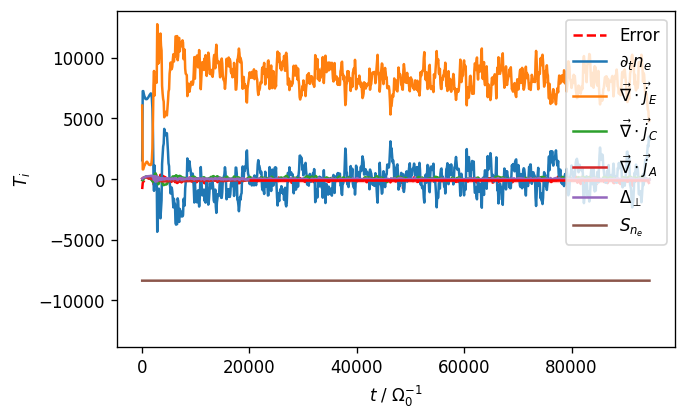

In [14]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot,ax,tau,res)
#     ax.set_yscale("linear")


plt.legend()
plt.show()

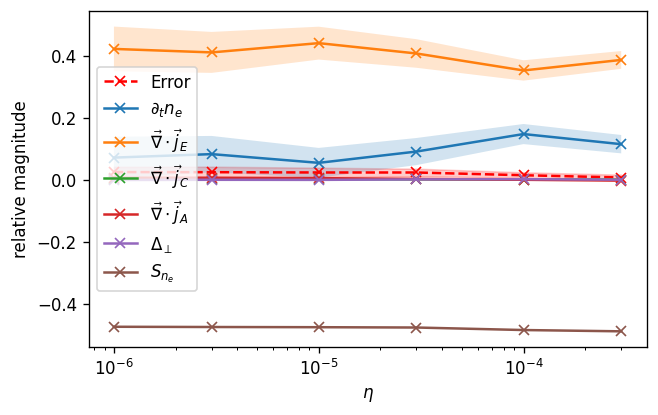

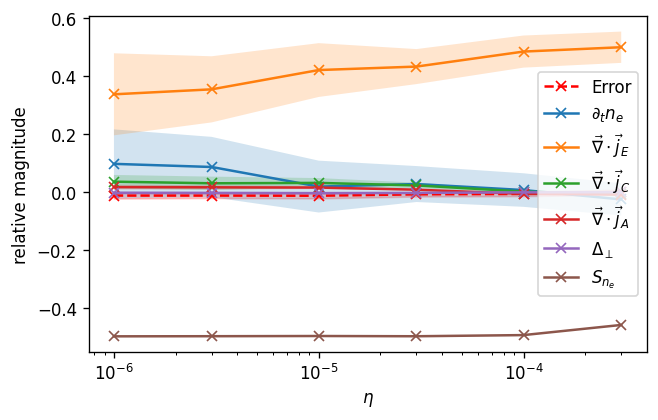

In [15]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

In [16]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : True, "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvee_tt_ifs_lcfs','jvei_tt_ifs_lcfs','jveea_tt_ifs_lcfs','jveia_tt_ifs_lcfs'],
        "derive" : False, "signs" : [+1,1,1,1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 1,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 8,
        "label" :  r"$R$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}
make_to_plot(to_plot_energy)


Mean error is  -1365.5110716166546  std error is  646.3569904894309


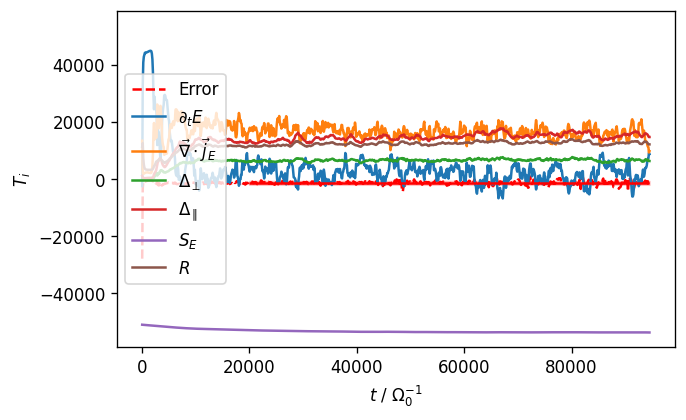

In [17]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_energy,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

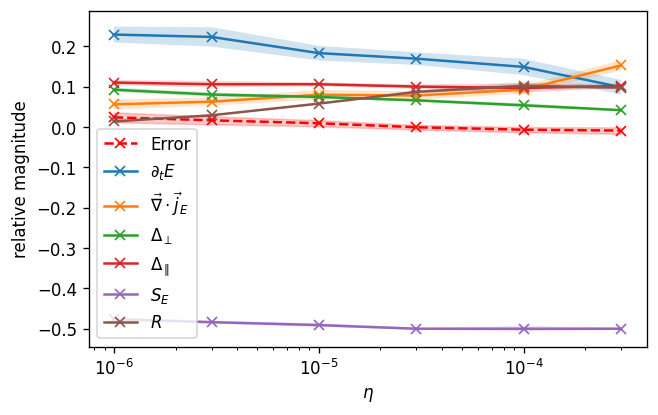

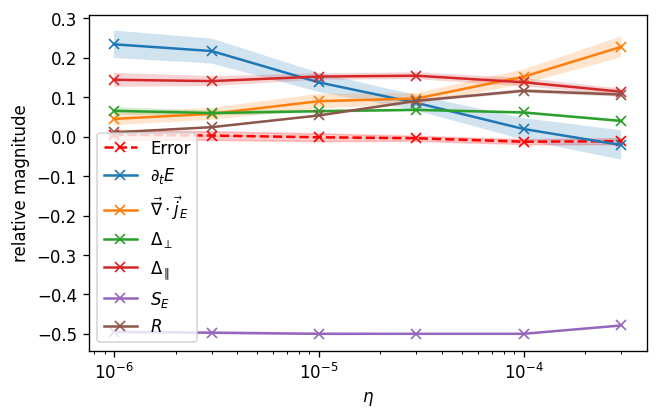

In [18]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

### Vorticity accuracy on LCFS

In [19]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
#         "names" : ['oexbe_fsa'], # bad for tau = 1
        "names" : ['oexbe_fsa','odiae_fsa'],
#     vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
        "idx":idx, "derive" : True,"signs" : [+1,1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E + \Omega_D)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbi_tt_ifs'],
        "names" : ['jvoexbe_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec j_\Omega,E$",
        "vals": {0:dict(),1:dict()},
    },    
    {
#         "names" : ['jvoexbeUD_tt_ifs'], # bad for tau = 1
#         "names" : ['jvoexbiUD_tt_ifs'], # also quite bad
        "names" : ['jvodiaeUE_tt_ifs'],
#         "names" : ['jvodiaiUE_tt_ifs'], # above 10%
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_\Omega,D$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['jvoapar_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 8,
        "label" : r"$Maxwell$",
        "vals": {0:dict(),1:dict()},
    },
#     {
# #         "names" : ['jvoexbApar_tt_ifs'],
#         "names" : ['jvodiaApar_tt_ifs'],
#         "idx": idx,"derive" : False, "signs" : [+1],
#         "color": 9,
#         "label" : r"$\vec \nabla\cdot\vec j_{\Omega,D,A}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['loexbe_tt_fsa'],"idx":idx, "derive" : False, "sign" : -1,
#         "color": 1,
#         "label" :  r"$\Lambda$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['socurve_tt_fsa','socurvi_tt_fsa','socurvkappae_tt_fsa','socurvkappai_tt_fsa'],
#     # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
        "idx":idx, "derive" : False, "signs" : [-1,-1,-1,-1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    }
#     {
#         "names" : [''], "derive" : False, "sign" : -1,
#     # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
#     # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
#         "color": 7,
#         "label" :  r"$S_{E}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_vorticity)


Mean error is  -3.776907551196281e-07  std error is  1.5565331388772432e-06


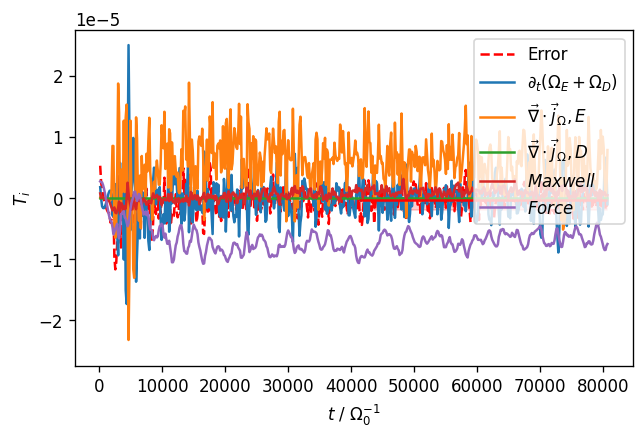

In [20]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-5
plot_series(to_plot_vorticity,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

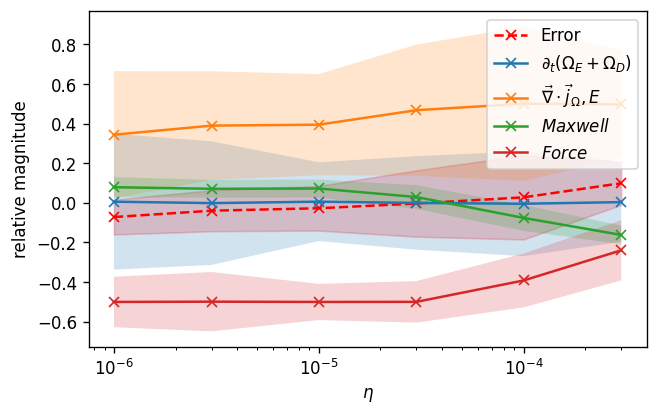

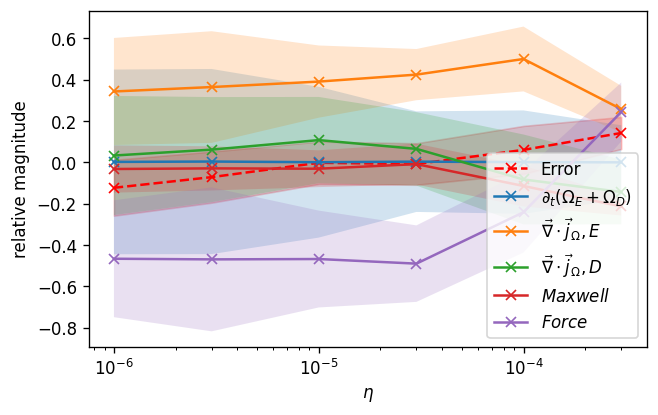

In [21]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

In [22]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : True, "signs" : [+1,-1],
        "color": 0,
        "label" : r"$\partial_t n_e-N_i$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 1,
        "label" : r"$\vec \nabla\cdot\vec j_E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 9,
        "label" : r"$\vec \nabla\cdot\vec j_A$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs','jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 2,
        "label" : r"$\vec \nabla\cdot\vec j_C$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
#         "color": 3,
#         "label" : r"$\vec \nabla\cdot\vec j_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # 1e-6 for both 
#         "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # lniperp has a mistake
# #         "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "names" : ['loexbe_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 5,
#         "label" : r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "color": 6,
#         "label" : r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },

    ]
}
make_to_plot(to_plot_mass_diff)


Mean error is  633.2716079547362  std error is  159.17527480179209


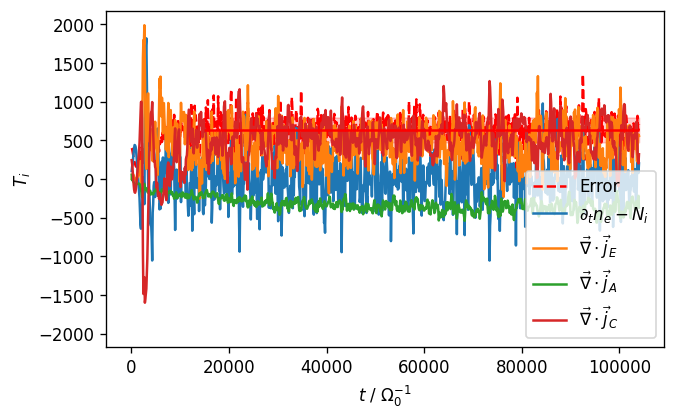

In [23]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 3e-4
plot_series(to_plot_mass_diff,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

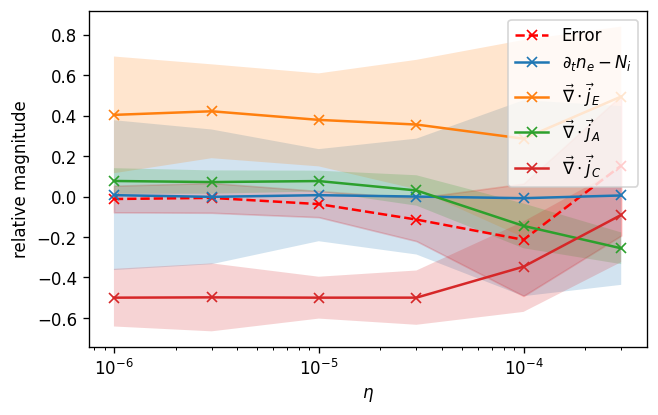

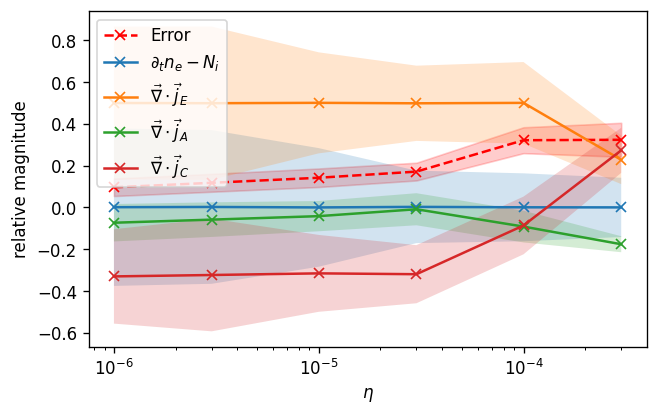

In [24]:
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

## Ion parallel momentum

In [25]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparexbi_tt_ifs_lcfs','jvparApar_tt_ifs_lcfs',
                   'jvpardiai_tt_ifs_lcfs','jvparkappai_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1,1,1,1],
        "color": 5,
        "label" : r"$\vec \nabla\cdot\vec (j_E+j_A)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrore_tt_ifs_lcfs","sparmirrori_tt_ifs_lcfs"],
        "derive" : False, "signs" : [-1,-1],
        "color": 2,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
#     divjpar = np.asarray(da['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(da['divjpari_tt_ifs_lcfs'][:])/deltat
#     { # is zero
#         "names" : ['sparsni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [-2],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },]
}
make_to_plot(to_plot_momentum)


Mean error is  132.52084179776787  std error is  123.77136097217104


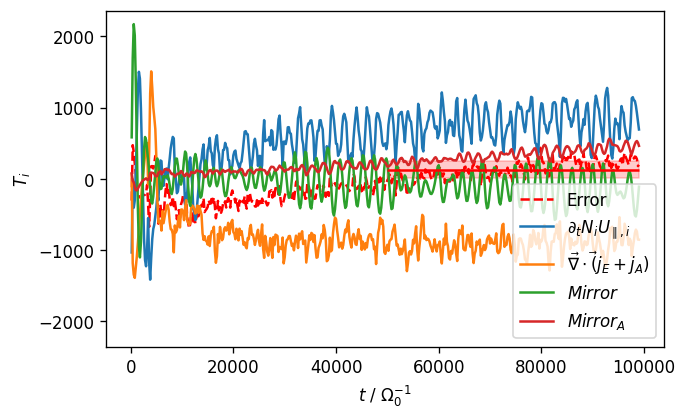

In [26]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-6
if tau == 0:
    to_plot_momentum["fields"][-1]["signs"] = [-1]
if tau == 1:
    to_plot_momentum["fields"][-1]["signs"] = [-2]
plot_series(to_plot_momentum,ax,tau,res)
low, high = ax.get_ylim()
bound = max(abs(low), abs(high))
ax.set_ylim(-bound, bound)

plt.legend()
plt.show()

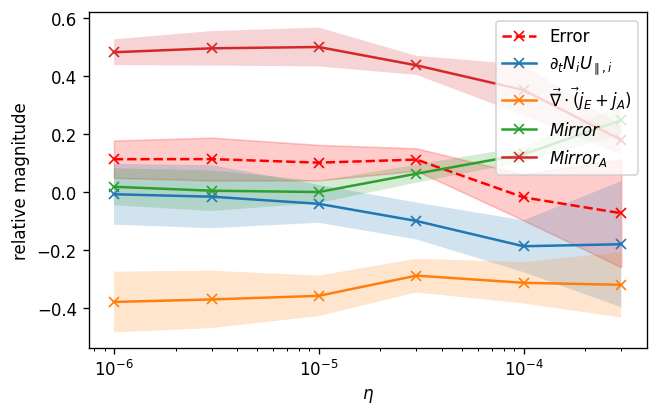

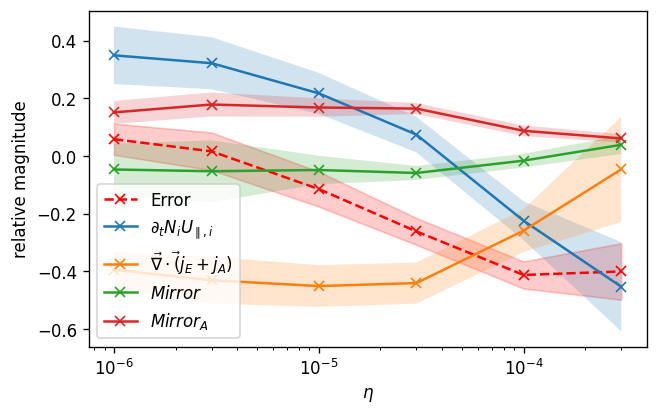

In [27]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    if tau == 0:
        to_plot_momentum["fields"][-1]["signs"] = [-1]
    if tau == 1:
        to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_momentum,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()

## Parallel electron force balance

In [28]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['friction_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 2,
        "label" : r"$\eta$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphie_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 8,
        "label" : r"$n_e\dot A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
#     { # it works better without ...
#         "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_electron_force)


Mean error is  -37.29088492182939  std error is  29.831168556517987


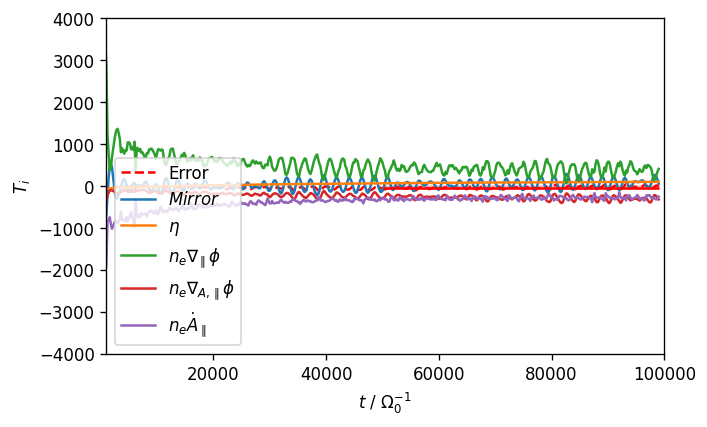

In [29]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-6
plot_series(to_plot_electron_force,ax,tau,res)
low, high = ax.get_ylim()
bound = 4000# max(abs(low), abs(high))
ax.set_ylim(-bound, bound)
ax.set_xlim(1000,100000)
plt.legend()
plt.show()

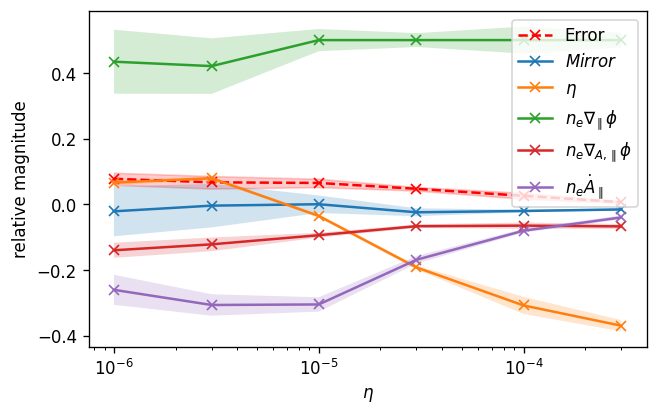

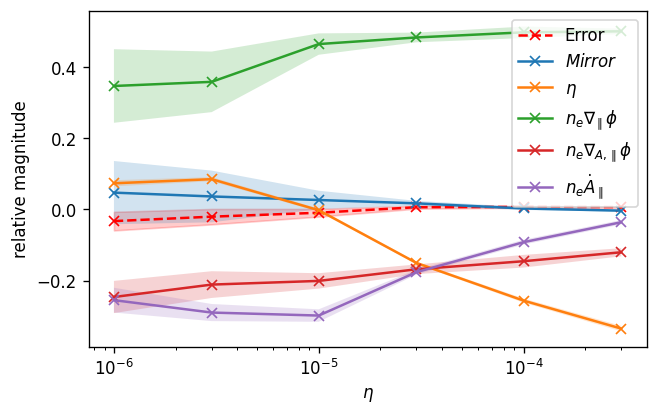

In [30]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    if tau == 0:
        to_plot_momentum["fields"][-1]["signs"] = [-1]
    if tau == 1:
        to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_electron_force,ax,tau)
#     ax.set_yscale("linear")
    plt.legend()
    plt.show()